# Accessing versioned data

The Delphi Epidata API stores not just each signal's estimate for a given
location on a given day, but also *when* that estimate was made, and all updates
to that estimate.

For example, let's look at the [doctor visits
signal](https://cmu-delphi.github.io/delphi-epidata/api/covidcast-signals/doctor-visits.html)
from the [covidcast
endpoint](https://cmu-delphi.github.io/delphi-epidata/api/covidcast.html), which
estimates the percentage of outpatient doctor visits that are COVID-related.

Consider a result row with `time_value = 2020-05-01` for `geo_values = "pa"`.
This is an estimate for Pennsylvania on May 1, 2020. That estimate was *issued*
on May 5, 2020 (which is recorded in the `issue` column), the delay coming from
a combination of:

- time taken by our data partner to collect the data
- time taken by the Dekohu Epidata API to ingest the data provided.

Later, the estimate for May 1st could be updated, perhaps because additional
visit data from May 1st arrived at our source and was reported to us. This
constitutes a new *issue* of the data.

## Data known "as of" a specific date

By default, endpoint functions fetch the most recent issue available. This is
the best option for users who simply want to graph the latest data or construct
dashboards. But if we are interested in knowing *when* data was reported, we can
request specific data versions using the `as_of`, `issues`, or `lag` arguments
(note that these are mutually exclusive and that not all endpoints aside from
`pub_covidcast` support all three parameters, so please check the documentation
for that specific endpoint).

First, we can request the data that was available *as it was available* on a
specific date, using the `as_of` argument:

In [1]:
# Hidden cell (set in the metadata for this cell)
import pandas as pd

# Set common options and context
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)
pd.set_option("display.width", 1000)

In [2]:
from epidatpy import EpiDataContext, EpiRange

epidata = EpiDataContext(use_cache=False)

# Obtain the most up-to-date version of the smoothed covid-like illness (CLI)
# signal from the COVID-19 Trends and Impact survey for the US
epidata.pub_covidcast(
    data_source="doctor-visits",
    signals="smoothed_cli",
    time_type="day",
    time_values="2020-05-01",
    geo_type="state",
    geo_values="pa",
    as_of="2020-05-07",
).df()

,source,signal,geo_type,geo_value,time_type,time_value,issue,lag,value,stderr,sample_size,direction,missing_value,missing_stderr,missing_sample_size
0,doctor-visits,smoothed_cli,state,pa,day,2020-05-01,2020-05-07,6,2.32192,<NA>,<NA>,<NA>,0,5,5


This shows that an estimate of about 2.3% was issued on May 7. If we don't
specify `as_of`, we get the most recent estimate available:

In [3]:
epidata.pub_covidcast(
    data_source="doctor-visits",
    signals="smoothed_cli",
    time_type="day",
    time_values="2020-05-01",
    geo_type="state",
    geo_values="pa",
).df()

,source,signal,geo_type,geo_value,time_type,time_value,issue,lag,value,stderr,sample_size,direction,missing_value,missing_stderr,missing_sample_size
0,doctor-visits,smoothed_cli,state,pa,day,2020-05-01,2020-07-04,64,5.075015,<NA>,<NA>,<NA>,0,5,5


Note the substantial change in the estimate, from less than 3% to over 5%,
reflecting new data that became available after May 7 about visits *occurring on*
May 1. This illustrates the importance of issue date tracking, particularly
for forecasting tasks. To backtest a forecasting model on past data, it is
important to use the data that would have been available *at the time* the model
was or would have been fit, not data that arrived much later.

By plotting API results with different values of the `as_of` parameter, we can
see how the indicator value changes over time as new observations become available:

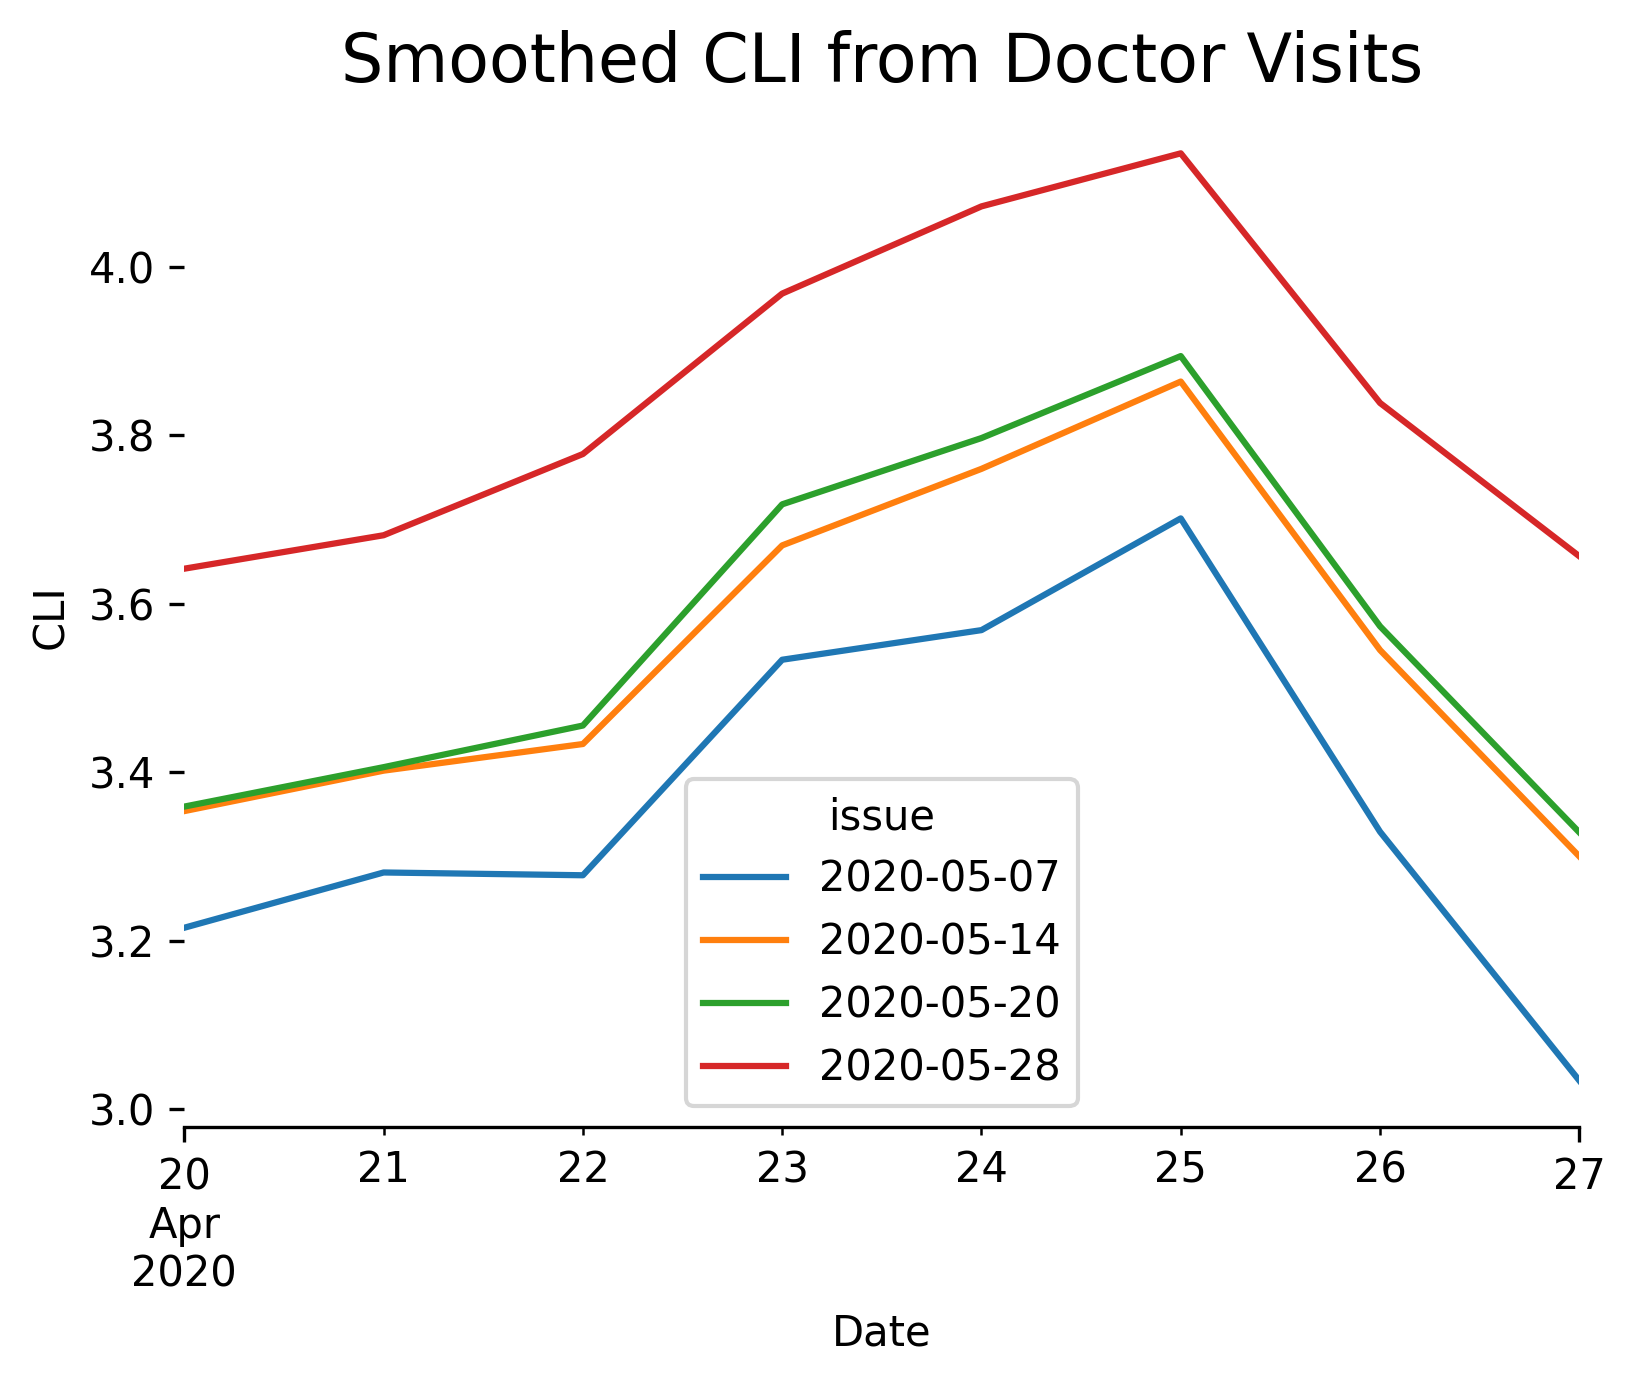

In [4]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300

results = []
for as_of_date in ["2020-05-07", "2020-05-14", "2020-05-21", "2020-05-28"]:
    apicall = epidata.pub_covidcast(
        data_source="doctor-visits",
        signals="smoothed_adj_cli",
        time_type="day",
        time_values=EpiRange("2020-04-20", "2020-04-27"),
        geo_type="state",
        geo_values="pa",
        as_of=as_of_date,
    )

    results.append(apicall.df())

final_df = pd.concat(results)
final_df["issue"] = final_df["issue"].dt.date

fig, ax = plt.subplots(figsize=(6, 5))
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

final_df.pivot_table(values="value", index="time_value", columns="issue").plot(
    xlabel="Date", ylabel="CLI", ax=ax, linewidth=1.5
)

plt.title("Smoothed CLI from Doctor Visits", fontsize=16)
plt.subplots_adjust(bottom=0.2)
plt.show()

## Multiple issues of observations

By using the `issues` argument, we can request all issues in a certain time
period:

In [5]:
epidata.pub_covidcast(
    data_source="doctor-visits",
    signals="smoothed_adj_cli",
    time_type="day",
    time_values="2020-05-01",
    geo_type="state",
    geo_values="pa",
    issues=EpiRange("2020-05-01", "2020-05-15"),
).df()

,source,signal,geo_type,geo_value,time_type,time_value,issue,lag,value,stderr,sample_size,direction,missing_value,missing_stderr,missing_sample_size
0,doctor-visits,smoothed_adj_cli,state,pa,day,2020-05-01,2020-05-07,6,2.581509,<NA>,<NA>,<NA>,0,5,5
1,doctor-visits,smoothed_adj_cli,state,pa,day,2020-05-01,2020-05-08,7,3.278896,<NA>,<NA>,<NA>,0,5,5
2,doctor-visits,smoothed_adj_cli,state,pa,day,2020-05-01,2020-05-09,8,3.321781,<NA>,<NA>,<NA>,0,5,5
3,doctor-visits,smoothed_adj_cli,state,pa,day,2020-05-01,2020-05-12,11,3.588683,<NA>,<NA>,<NA>,0,5,5
4,doctor-visits,smoothed_adj_cli,state,pa,day,2020-05-01,2020-05-13,12,3.631978,<NA>,<NA>,<NA>,0,5,5
5,doctor-visits,smoothed_adj_cli,state,pa,day,2020-05-01,2020-05-14,13,3.658009,<NA>,<NA>,<NA>,0,5,5
6,doctor-visits,smoothed_adj_cli,state,pa,day,2020-05-01,2020-05-15,14,3.662286,<NA>,<NA>,<NA>,0,5,5


This estimate was clearly updated many times as new data for May 1st arrived.
Note that these results include only data issued or updated between (inclusive)
2020-05-01 and 2020-05-15. If a value was first reported on 2020-04-15, and
never updated, a query for issues between 2020-05-01 and 2020-05-15 will not
include that value among its results. This view of the data is useful for
understanding the revision patterns in a signal and can be useful for nowcasting
(i.e. the practice of auto-correcting real-time estimates).

## Observations issued with a specific lag

Finally, we can use the `lag` argument to request only data reported with a
certain lag. For example, requesting a lag of 7 days fetches only data issued
exactly 7 days after the corresponding `time_value`:

In [6]:
epidata.pub_covidcast(
    data_source="doctor-visits",
    signals="smoothed_adj_cli",
    time_type="day",
    time_values=EpiRange("2020-05-01", "2020-05-01"),
    geo_type="state",
    geo_values="pa",
    lag=7,
).df()

,source,signal,geo_type,geo_value,time_type,time_value,issue,lag,value,stderr,sample_size,direction,missing_value,missing_stderr,missing_sample_size
0,doctor-visits,smoothed_adj_cli,state,pa,day,2020-05-01,2020-05-08,7,3.278896,<NA>,<NA>,<NA>,0,5,5


Note that though this query requested all values between 2020-05-01 and
2020-05-07, May 3rd and May 4th were *not* included in the results set. This is
because the query will only include a result for May 3rd if a value were issued
on May 10th (a 7-day lag), but in fact the value was not updated on that day:

In [7]:
epidata.pub_covidcast(
    data_source="doctor-visits",
    signals="smoothed_adj_cli",
    time_type="day",
    time_values="2020-05-03",
    geo_type="state",
    geo_values="pa",
    issues=EpiRange("2020-05-09", "2020-05-15"),
).df()

,source,signal,geo_type,geo_value,time_type,time_value,issue,lag,value,stderr,sample_size,direction,missing_value,missing_stderr,missing_sample_size
0,doctor-visits,smoothed_adj_cli,state,pa,day,2020-05-03,2020-05-09,6,2.788618,<NA>,<NA>,<NA>,0,5,5
1,doctor-visits,smoothed_adj_cli,state,pa,day,2020-05-03,2020-05-12,9,3.015368,<NA>,<NA>,<NA>,0,5,5
2,doctor-visits,smoothed_adj_cli,state,pa,day,2020-05-03,2020-05-13,10,3.03931,<NA>,<NA>,<NA>,0,5,5
3,doctor-visits,smoothed_adj_cli,state,pa,day,2020-05-03,2020-05-14,11,3.021245,<NA>,<NA>,<NA>,0,5,5
4,doctor-visits,smoothed_adj_cli,state,pa,day,2020-05-03,2020-05-15,12,3.048725,<NA>,<NA>,<NA>,0,5,5
